# Ottimizzazione del portafoglio 

## Impostazione dell'ambiente

Iniziamo con l'importare le librerie per l'analisi dei dati

In [1]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

Passiamo poi alle librerie per il supporto alla fattorizzazione

In [2]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity 
from factor_analyzer.factor_analyzer import calculate_kmo

Alla fine importiamo anche le librerie per il machine learning

In [3]:
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

Ora da un insieme di ticker creo un dataset con i rendimenti giornalieri dei cari titoli

In [4]:
tickers = ['FRCB','PNC','USB','JPM','BAC','C','RY','WFC','GS','MS','HSBC','JNJ','PFE','MRK','XOM','SHEL','CVS','BP','AAPL','GOOG','MSFT','BABA','^GSPC']

years = 10

period = '{0}y'.format(years)
data = yf.download(tickers, period=period)
df = data['Adj Close'].pct_change()
df = df.iloc[1:, :] 
df

[*********************100%%**********************]  23 of 23 completed


Ticker,AAPL,BABA,BAC,BP,C,CVS,FRCB,GOOG,GS,HSBC,...,MS,MSFT,PFE,PNC,RY,SHEL,USB,WFC,XOM,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-21,0.007634,0.032487,0.009830,0.029981,0.010157,0.011487,1.538463e-02,0.021977,0.008654,0.008818,...,-0.000575,-0.010131,-0.013897,0.001891,-0.001606,0.015947,0.024023,0.001923,0.008563,0.004732
2015-01-22,0.026015,0.006874,0.044127,0.004122,0.038332,0.007840,6.265361e-02,0.031561,0.027604,0.023602,...,0.023035,0.026350,0.005209,0.026893,-0.020990,0.003657,0.029147,0.032054,0.010885,0.015270
2015-01-23,0.005160,-0.008558,-0.022374,-0.002052,-0.019165,0.003390,-1.329477e-02,0.010404,-0.008515,-0.000213,...,-0.010695,0.001061,-0.010972,-0.008959,0.007800,-0.010173,-0.002533,-0.009485,-0.021320,-0.005492
2015-01-26,0.001062,0.008535,0.007629,0.026221,0.005553,0.003876,8.982443e-03,-0.008779,-0.000388,0.010250,...,-0.001138,-0.003603,0.010786,0.005795,-0.005270,0.019328,0.004848,0.006009,0.009572,0.002568
2015-01-27,-0.035013,-0.010097,-0.013880,0.007264,-0.011863,-0.001881,1.570462e-07,-0.030978,-0.021782,-0.007187,...,-0.012817,-0.092534,-0.006098,-0.014750,0.002152,0.003612,-0.012635,-0.011385,-0.008828,-0.013388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,-0.024104,-0.037758,-0.023804,0.005463,-0.025389,0.043469,4.651155e-02,-0.011362,-0.034516,-0.000405,...,-0.034491,-0.013214,-0.005212,-0.029073,-0.026712,0.003399,-0.023495,-0.022495,-0.003647,-0.015412
2025-01-13,-0.010344,0.000124,-0.001108,-0.002237,0.019188,0.073110,1.111111e-01,-0.004556,0.005268,-0.007092,...,0.004374,-0.004201,0.002994,0.018040,0.002956,0.000308,0.021317,0.008148,0.025812,0.001575
2025-01-14,-0.004778,0.014154,0.015979,-0.004164,0.010032,0.000970,2.000006e-02,-0.006449,0.015241,0.007143,...,0.005081,-0.003643,-0.014552,0.017045,-0.001179,0.014624,0.013846,0.009358,0.003934,0.001146


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,2514.0,0.001053,0.017923,-0.128647,-0.007379,0.000970,0.010117,0.119808
BABA,2514.0,0.000274,0.026211,-0.133422,-0.012821,-0.000426,0.012865,0.367639
BAC,2514.0,0.000718,0.019563,-0.153973,-0.009057,0.000409,0.010453,0.177962
BP,2514.0,0.000362,0.019762,-0.191040,-0.008699,0.000255,0.009042,0.216053
C,2514.0,0.000522,0.020666,-0.192986,-0.009114,0.000382,0.009910,0.179843
CVS,2514.0,0.000003,0.017296,-0.168365,-0.008094,0.000372,0.008949,0.113300
FRCB,2514.0,0.002644,0.121218,-0.904957,-0.011244,0.000000,0.011212,1.800000
GOOG,2514.0,0.000974,0.017965,-0.111008,-0.007139,0.001177,0.009503,0.160524
GS,2514.0,0.000741,0.018190,-0.127053,-0.008312,0.000547,0.010205,0.175803


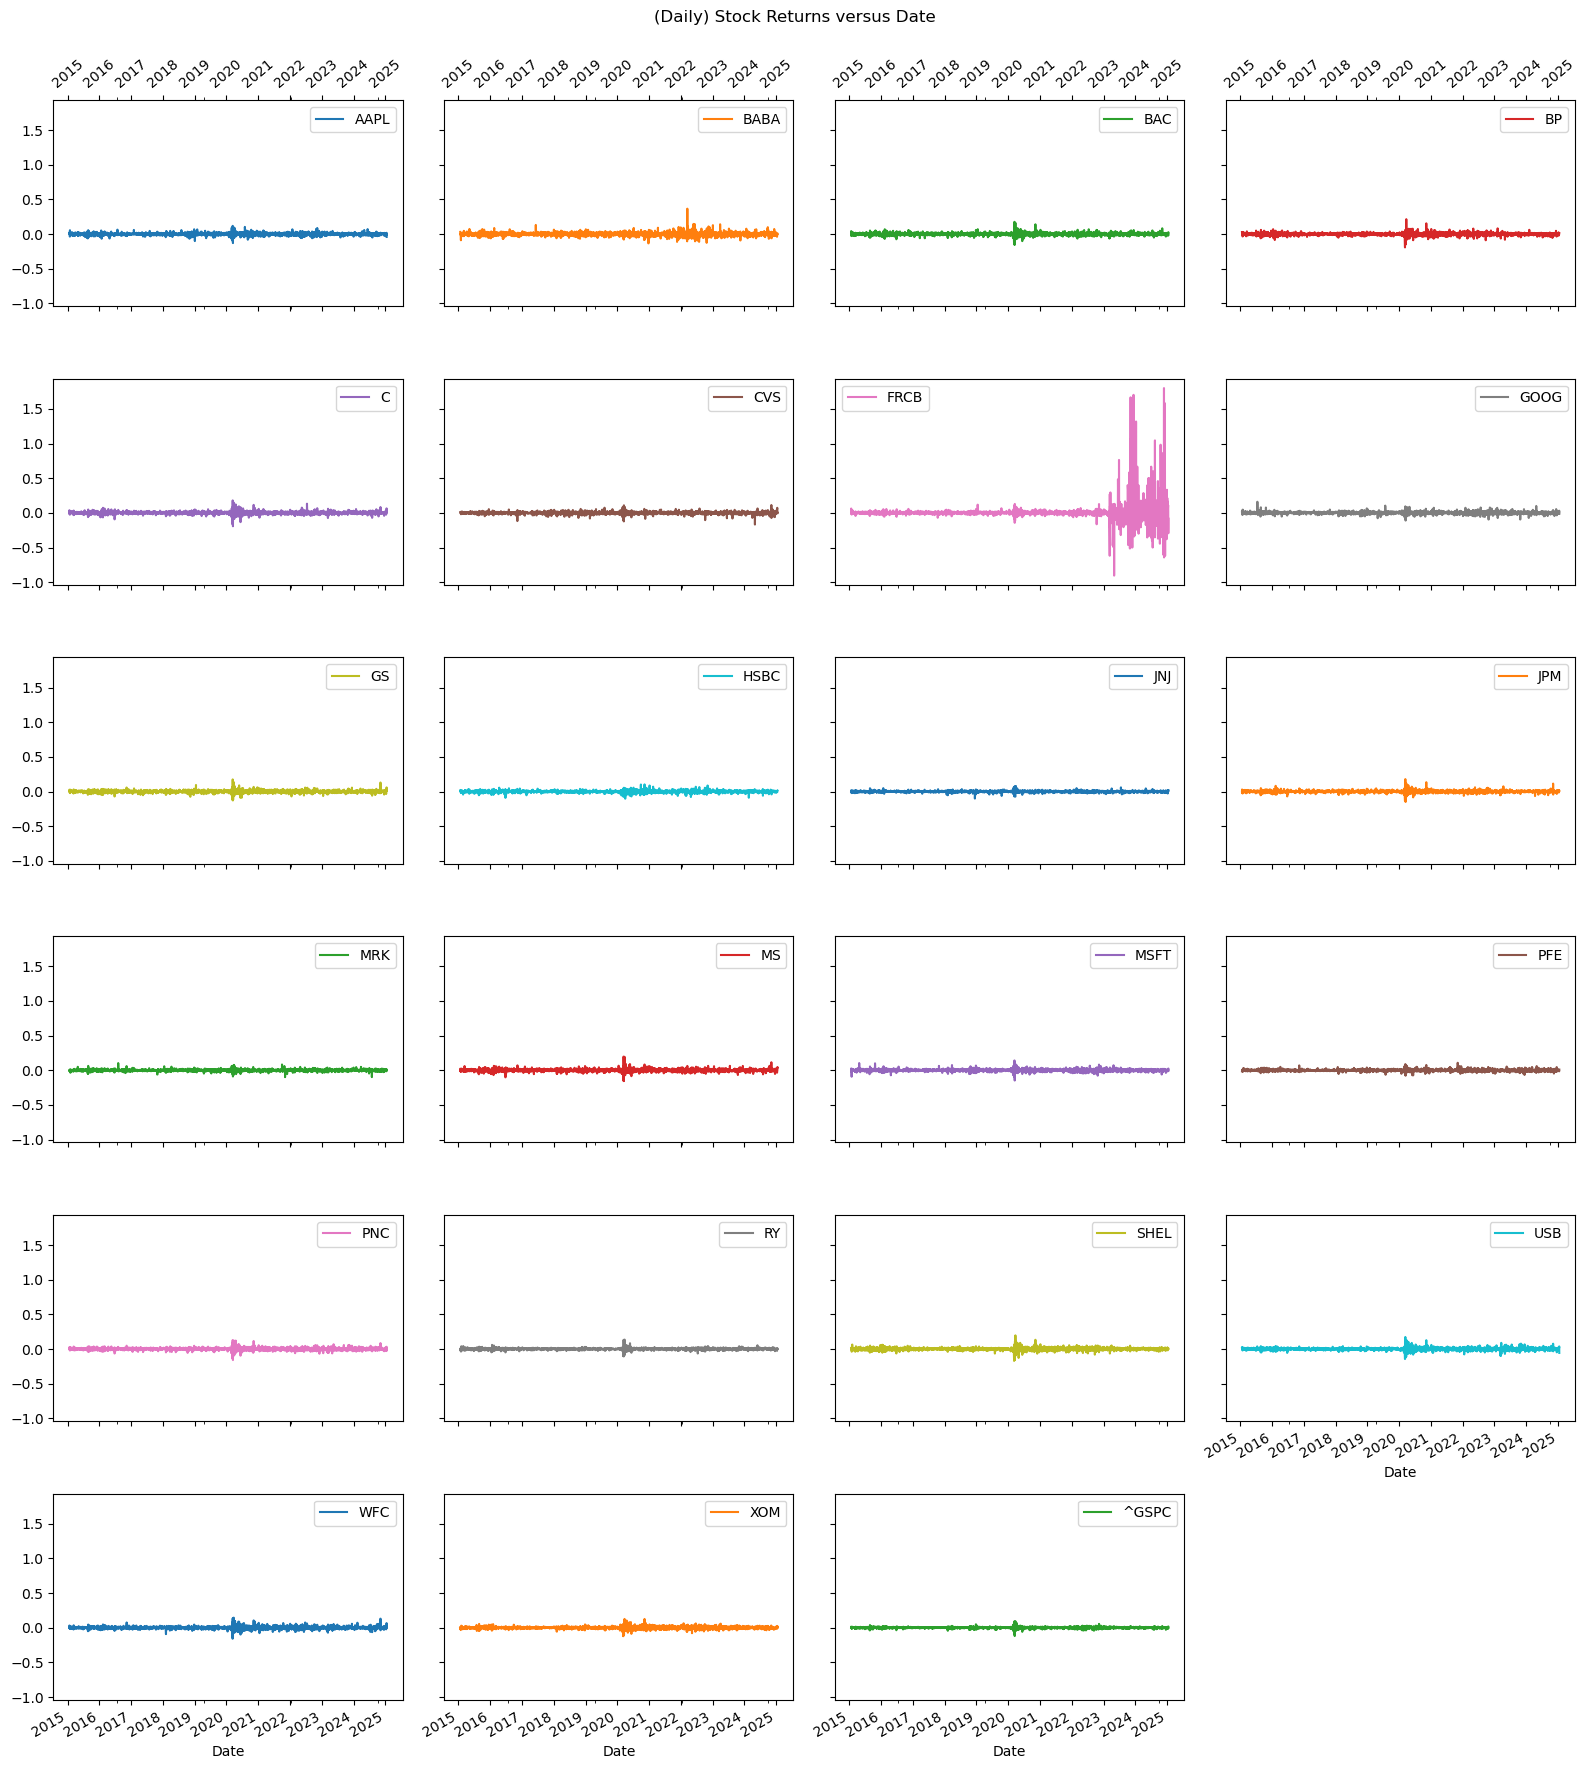

In [6]:
n = len(df.columns) 
col = 4 #specifico il numero di colonne dei grafici da creaere
row = int(np.ceil(n/col)) #calcolo il numero di righe
fig_hei = row * 3 
fig_wid = col * 4

ax = df.plot(subplots=True, layout=(row ,col), figsize=(fig_wid, fig_hei),
             sharey=True, sharex=True, #share y and x axis for the subplots
             title = '(Daily) Stock Returns versus Date')

for i in range(col): #Imposto il ticker per ogni titolo
    ax[0,i].xaxis.set_tick_params(which='both', top = True, labeltop=True, labelrotation=40) 
    
    
fig = ax[0,0].get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.93) 

Controlliamo che il dataset non contenga righe vuote

In [7]:
print(df.isnull().values.any())

False


## Cambiamo la frequenza dei dati

possiamo convertire i rendimenti in frequenze diverse usando la funzione [resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) nel nostro caso calcoliamo i rendimenti settimanali sommando 1 moltiplicando i valori e sottraendo uno alla fine, togliamo la prima e l'ultima settimana perchè potrebbero non essere complete.

In [8]:
df_week = (df+1).resample('W').prod() - 1
df_week = df_week.iloc[1:-1]
df_week

Ticker,AAPL,BABA,BAC,BP,C,CVS,FRCB,GOOG,GS,HSBC,...,MS,MSFT,PFE,PNC,RY,SHEL,USB,WFC,XOM,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,0.036998,-0.136068,-0.036872,-0.001800,-0.034143,-0.024448,-2.961638e-03,-0.010056,-0.044767,-0.023703,...,-0.035340,-0.143705,-0.036980,-0.020167,-0.068171,-0.057371,-0.032549,-0.025159,-0.038178,-0.027697
2015-02-08,0.019113,-0.038168,0.088449,0.060263,0.046646,0.024959,8.464250e-02,-0.006585,0.063917,0.029746,...,0.058563,0.049753,0.070804,0.069790,0.072981,0.077950,0.059652,0.055641,0.054550,0.030316
2015-02-15,0.068528,0.039332,0.007277,0.033492,0.041921,0.020077,2.136536e-02,0.033917,0.030366,-0.020179,...,0.027661,0.034426,0.044317,0.021451,0.025362,0.015656,0.014862,0.016162,0.020437,0.020200
2015-02-22,0.019043,-0.027063,-0.013848,-0.015502,0.011328,0.000682,3.900109e-03,-0.018324,0.013280,0.011923,...,-0.001087,0.006887,-0.002310,-0.001191,-0.026823,-0.007841,-0.009985,-0.009037,-0.036950,0.006347
2015-03-01,-0.008031,-0.017544,-0.034798,0.003876,0.012360,0.011392,6.533447e-03,0.036089,-0.005870,-0.044130,...,-0.025857,-0.000228,-0.006945,-0.003360,0.033504,-0.006535,-0.000224,-0.000730,-0.015347,-0.002748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-15,0.021784,0.021995,-0.023102,0.044599,-0.015800,-0.107072,-6.825397e-01,0.085598,-0.023679,0.021223,...,-0.019698,0.008341,-0.005830,-0.034175,-0.012297,0.004585,-0.022039,-0.052334,-0.024038,-0.006433
2024-12-22,0.025632,-0.063084,-0.032844,-0.046031,-0.025630,-0.101479,2.220446e-16,0.008256,-0.033101,-0.006790,...,-0.031083,-0.023856,0.030493,-0.043375,-0.030361,-0.045641,-0.060945,-0.001420,-0.044839,-0.019871
2024-12-29,0.004322,0.033787,0.003849,0.012587,0.026160,0.002931,-4.000000e-01,0.005597,0.017806,0.021131,...,0.026896,-0.013903,0.009863,0.002698,0.001325,0.017315,0.011895,0.010947,0.005762,0.006743


## Estrazione S\&P500

Questo è un indice che non verrà usato nel portafoglio estraiamo la colonna

In [9]:
SP500 = df_week[['^GSPC']].copy()
SP500.rename(columns={'^GSPC':'SP500'}, inplace=True)
SP500

Ticker,SP500
Date,
2015-02-01,-0.027697
2015-02-08,0.030316
2015-02-15,0.020200
2015-02-22,0.006347
2015-03-01,-0.002748
...,...
2024-12-15,-0.006433
2024-12-22,-0.019871
2024-12-29,0.006743


Ora rimuoviamo la colonna dal dataframe principale

In [10]:
if '^GSPC' in df_week.columns:
    df_week.drop('^GSPC',axis = 1,inplace=True)
df_week

Ticker,AAPL,BABA,BAC,BP,C,CVS,FRCB,GOOG,GS,HSBC,...,MRK,MS,MSFT,PFE,PNC,RY,SHEL,USB,WFC,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,0.036998,-0.136068,-0.036872,-0.001800,-0.034143,-0.024448,-2.961638e-03,-0.010056,-0.044767,-0.023703,...,-0.035366,-0.035340,-0.143705,-0.036980,-0.020167,-0.068171,-0.057371,-0.032549,-0.025159,-0.038178
2015-02-08,0.019113,-0.038168,0.088449,0.060263,0.046646,0.024959,8.464250e-02,-0.006585,0.063917,0.029746,...,-0.024718,0.058563,0.049753,0.070804,0.069790,0.072981,0.077950,0.059652,0.055641,0.054550
2015-02-15,0.068528,0.039332,0.007277,0.033492,0.041921,0.020077,2.136536e-02,0.033917,0.030366,-0.020179,...,0.000340,0.027661,0.034426,0.044317,0.021451,0.025362,0.015656,0.014862,0.016162,0.020437
2015-02-22,0.019043,-0.027063,-0.013848,-0.015502,0.011328,0.000682,3.900109e-03,-0.018324,0.013280,0.011923,...,-0.007822,-0.001087,0.006887,-0.002310,-0.001191,-0.026823,-0.007841,-0.009985,-0.009037,-0.036950
2015-03-01,-0.008031,-0.017544,-0.034798,0.003876,0.012360,0.011392,6.533447e-03,0.036089,-0.005870,-0.044130,...,0.003256,-0.025857,-0.000228,-0.006945,-0.003360,0.033504,-0.006535,-0.000224,-0.000730,-0.015347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-15,0.021784,0.021995,-0.023102,0.044599,-0.015800,-0.107072,-6.825397e-01,0.085598,-0.023679,0.021223,...,-0.010573,-0.019698,0.008341,-0.005830,-0.034175,-0.012297,0.004585,-0.022039,-0.052334,-0.024038
2024-12-22,0.025632,-0.063084,-0.032844,-0.046031,-0.025630,-0.101479,2.220446e-16,0.008256,-0.033101,-0.006790,...,-0.031031,-0.031083,-0.023856,0.030493,-0.043375,-0.030361,-0.045641,-0.060945,-0.001420,-0.044839
2024-12-29,0.004322,0.033787,0.003849,0.012587,0.026160,0.002931,-4.000000e-01,0.005597,0.017806,0.021131,...,0.016828,0.026896,-0.013903,0.009863,0.002698,0.001325,0.017315,0.011895,0.010947,0.005762


Andiamo ora a leggere i valori dei tassi di rendimento risk free, questi ci serviranno per calcolare lo Sharpe Ratio
Useremo come riferimento i Treasury Bill (T-Bill) obbligazioni statali americane a breve scadenza.

Questi li possiamo ottenere dal sito della federal reserve
https://fred.stlouisfed.org/series/WTB3MS#0

In [11]:
from dataloader import get_fed_data
from datetime import date
from dateutil.relativedelta import relativedelta

end_date = date.today()
start_date = end_date - relativedelta(years=years)

fed_data = get_fed_data('WTB3MS',start_date,end_date)
fed_data

2015-01-23    0.03
2015-01-30    0.02
2015-02-06    0.02
2015-02-13    0.01
2015-02-20    0.02
              ... 
2024-12-13    4.26
2024-12-20    4.24
2024-12-27    4.24
2025-01-03    4.22
2025-01-10    4.21
Length: 521, dtype: float64

Come si vede dalla serie i rendimenti sono annuallizzati, e vengono restituiti ogni venerdì dobbiamo aggiustare i valori al fine di renderli compatibili con il dataframe precedente

In [12]:
# In un anno ci sono 52 settimana 
Freq = 52 

In [13]:
fed_data = (fed_data / 100 + 1) ** (1/Freq) - 1

In [14]:
fed_data

2015-01-23    0.000006
2015-01-30    0.000004
2015-02-06    0.000004
2015-02-13    0.000002
2015-02-20    0.000004
                ...   
2024-12-13    0.000803
2024-12-20    0.000799
2024-12-27    0.000799
2025-01-03    0.000795
2025-01-10    0.000793
Length: 521, dtype: float64

In [15]:
fed_data = (fed_data + 1).resample('W').prod() - 1
fed_data

2015-01-25    0.000006
2015-02-01    0.000004
2015-02-08    0.000004
2015-02-15    0.000002
2015-02-22    0.000004
                ...   
2024-12-15    0.000803
2024-12-22    0.000799
2024-12-29    0.000799
2025-01-05    0.000795
2025-01-12    0.000793
Freq: W-SUN, Length: 521, dtype: float64

Ora abbiamo tutto quello che ci serve siamo pronti per iniziare le nostre analisi cerchiamo di ottenere gli stessi indici per tutti i dataframe 

In [16]:
mindate = df_week.index.min()
maxdate = df_week.index.max()
ind = (fed_data.index >= mindate) & (fed_data.index <= maxdate)
ind

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [17]:
try:
    fed_data = fed_data[ind]
except:
    print("Errore nella gestione indici")

## Valutazione delle performance individuali 

partendo dai dati individuali di tutte le azioni calcoliamo:

* I rendimenti annuali
* La volatilità dei rendimenti
* Lo Sharpe ratio
* Il Max Drawdown

In [18]:
from utils import geometric_mean,annualize_vol, annualize_sharpe, max_drawdown,annualize_rets

n_dec = 2
SumStat = pd.DataFrame(index = df_week.columns)
SumStat['Geo Mean(Annu,%)'] = np.round(df_week.apply(geometric_mean, periods_per_year=Freq)*100, n_dec)
SumStat['Volatility(Annu,%)'] = np.round(annualize_vol(df_week, periods_per_year=Freq)*100 , n_dec)
SumStat['Sharpe Ratio (Annu)'] = np.round(df_week.apply(annualize_sharpe, risk_free_rate=fed_data,periods_per_year=Freq) , n_dec)
SumStat['Max Drawdown(%)'] = np.round(df_week.apply(max_drawdown)*100, n_dec)

In [19]:
SumStat.sort_values(by='Sharpe Ratio (Annu)')

,"Geo Mean(Annu,%)","Volatility(Annu,%)",Sharpe Ratio (Annu),Max Drawdown(%)
Ticker,,,,
CVS,-4.62,28.28,-0.77,-55.59
BABA,-2.10,39.94,1.23,-79.43
FRCB,-60.46,186.09,1.72,-100.00
PFE,2.56,22.72,1.74,-53.22
BP,3.78,31.32,3.15,-62.18
USB,4.41,28.72,3.32,-51.38
SHEL,5.30,29.74,4.01,-61.47
XOM,6.13,27.50,4.43,-59.76
WFC,5.76,31.67,4.48,-63.94


Ora che abbiamo i nostri dati vogliamo ottenere i coefficienti $\alpha$ e $\beta$

In [20]:
def regression(X,y):
    reg = LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))  # perform linear regression
    return reg.coef_,reg.intercept_

In [21]:
n_dec = 3

ex_ret = df_week.sub(fed_data, axis=0)
mkt_ex_ret = SP500.sub(fed_data,axis=0)

#per ogni azione calcoliamo alpha e beta
n = len(ex_ret.columns)
beta = np.zeros(n)
alpha = np.zeros(n)


for i in range(n):
    beta[i],alpha[i] = regression(mkt_ex_ret.values,ex_ret[ex_ret.columns[i]].values)

    
AlphaBeta = pd.DataFrame(index = df_week.columns)
AlphaBeta['Alpha(Annu,%)'] = np.round((alpha+1)**Freq-1, n_dec)
AlphaBeta['Beta'] = np.round(beta , n_dec)

AlphaBeta.sort_values(by='Alpha(Annu,%)')

,"Alpha(Annu,%)",Beta
Ticker,,
CVS,-0.102,0.824
BABA,-0.051,0.917
USB,-0.045,1.113
C,-0.037,1.366
PFE,-0.030,0.632
WFC,-0.029,1.160
BP,-0.024,0.923
SHEL,-0.013,0.907
FRCB,-0.008,1.496


## Calcolo della covarianza della matrice dei rendimenti

In [22]:
data_cov_mat = df_week.cov()
data_cov_mat_annu = data_cov_mat * Freq 

In [23]:
data_cov_mat_annu

Ticker,AAPL,BABA,BAC,BP,C,CVS,FRCB,GOOG,GS,HSBC,...,MRK,MS,MSFT,PFE,PNC,RY,SHEL,USB,WFC,XOM
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.072691,0.029679,0.028026,0.017746,0.032212,0.017250,0.029635,0.040971,0.031457,0.014530,...,0.011581,0.031859,0.039236,0.015370,0.025179,0.020100,0.015255,0.022720,0.020548,0.013357
BABA,0.029679,0.159534,0.026406,0.021927,0.032680,0.018852,0.047305,0.038451,0.029076,0.030551,...,0.013437,0.031751,0.027728,0.013543,0.024797,0.026955,0.021119,0.029162,0.021837,0.019048
BAC,0.028026,0.026406,0.096585,0.045728,0.087896,0.033198,0.087820,0.030842,0.077543,0.046367,...,0.015841,0.079357,0.025933,0.017986,0.077524,0.040409,0.043926,0.073153,0.081210,0.046237
BP,0.017746,0.021927,0.045728,0.098118,0.054862,0.028400,0.025426,0.018132,0.044039,0.034138,...,0.014608,0.045203,0.015357,0.017615,0.039290,0.034539,0.083042,0.042591,0.050309,0.065667
C,0.032212,0.032680,0.087896,0.054862,0.105287,0.034789,0.056508,0.033565,0.078555,0.049061,...,0.017630,0.079911,0.027214,0.019644,0.074507,0.045039,0.052407,0.072951,0.081067,0.049075
CVS,0.017250,0.018852,0.033198,0.028400,0.034789,0.079983,-0.011251,0.017659,0.032335,0.020568,...,0.021940,0.032669,0.017759,0.023867,0.031872,0.021456,0.027451,0.031335,0.029597,0.027990
FRCB,0.029635,0.047305,0.087820,0.025426,0.056508,-0.011251,3.463067,0.013324,0.080442,0.024017,...,0.017654,0.105379,0.025729,-0.032064,0.075668,0.058800,0.028766,0.102412,0.092510,0.031947
GOOG,0.040971,0.038451,0.030842,0.018132,0.033565,0.017659,0.013324,0.077051,0.030852,0.020148,...,0.008168,0.032922,0.043415,0.015664,0.025040,0.019094,0.017664,0.022824,0.025498,0.018476
GS,0.031457,0.029076,0.077543,0.044039,0.078555,0.032335,0.080442,0.030852,0.087625,0.038899,...,0.016462,0.077967,0.028161,0.021854,0.068454,0.040589,0.043325,0.063792,0.070404,0.043082


Controlliamo se la matrice è fattorizzable, il fatto che questa matrice sia fattorizzabile dovrebbe dirci che ci sono correlazioni significanti. 

Ci sono due metodi per controllare la fattoriabilità del dataset:

* Test di Barlett, questo test di sfericità controlla che le variabili siano intercorrelate tra loro o meno utilizzando la matrice di correlazione rispetto alla matrice identità, se questo test risulta statisticamente insignificante non possiamo utilizzare l'analisi fattoriale!

* Test di Kaiser-Meyer-Olkin (KMO) misura l'idoneità dei dati per l'analisi fattoriale e determina l'adeguatezza di ogni variabile osservata rispetto al modello completo, i valori variano tra 0 e 1 e un valore sotto al 0.6 è considerato inaccettabile
    

In [24]:
chi_square_value,p_value = calculate_bartlett_sphericity(df_week)
print("In this Bartlett ’s test, the p-value is:", p_value)
if (p_value < 0.05):
    print("The test was statistically significant; the observed correlation matrix is not an identity matrix.")

In this Bartlett ’s test, the p-value is: 0.0
The test was statistically significant; the observed correlation matrix is not an identity matrix.


In [25]:
kmo_all,kmo_model = calculate_kmo(df_week)
print("In this KOM test, the overall KMO is:", kmo_model)
if (kmo_model > 0.6):
    print("Value of KMO is greater than 0.6; you can adequately perform factor analysis with the data.")

In this KOM test, the overall KMO is: 0.9421220286312014
Value of KMO is greater than 0.6; you can adequately perform factor analysis with the data.


C:\ProgramData\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


## Stima dei parametri del modello di Markowitz

Cominciamo con la creazione del nostro dataset di train

In [26]:
import ipywidgets as widgets
from IPython.display import display

w_start = widgets.DatePicker(
    description='Start Date',
    value = mindate
)

display(w_start)

DatePicker(value=Timestamp('2015-02-01 00:00:00'), description='Start Date', step=1)

In [27]:
end_date = maxdate - relativedelta(months=6)


w_end = widgets.DatePicker(
    description='End Date',
    value = end_date
)

display(w_end)

DatePicker(value=Timestamp('2024-07-12 00:00:00'), description='End Date', step=1)

In [28]:
from datetime import timedelta
if pd.Timestamp(w_end.value) - pd.Timestamp(w_start.value) < timedelta(days=30):
    raise Exception("The start date must be earlier than the end date") 

In [29]:
if maxdate - pd.Timestamp(w_end.value) < timedelta(days=30):
    raise Exception("No enought test data") 

In [30]:
end_date - pd.Timestamp(w_end.value)

Timedelta('0 days 00:00:00')

In [31]:
ind = (df_week.index >= pd.Timestamp(w_start.value)) & (df_week.index <= pd.Timestamp(w_end.value))
df_train = df_week[ind].copy()
SP500_train = SP500[ind].copy()
fed_train = fed_data[ind].copy()

### Formulazione del problema di Markowitz

Dobbiamo minimizzare la variazianza del portafoglio con i seguenti vincoli:

* Vincolo di budget (vogliamo allorare il portafoglio intero) $$ \textbf{1}^T w = 1 $$
* Vincolo dei pesi non negativi $$w \geq 0$$
* Vincolo dei rendimenti  $$\mu^T w \geq \bar{r}$$

Con:

- $w$ = vettore dei pesi dei rendimenti
- $Q$ = matrice di covarianza
- $\textbf{1}$ = vettore unitario
- $\mu$ vettore dei rendimenti attesi
- $\bar{r}$ è il rendimento da superare

Quello di cui abbiamo bisogno è il **rendimento atteso** e la **matrice di covarianza**, per semplicità assumiamo che il rendimento atteso sia la media storica (approssimazione molto pericolosa) stessa cosa per la matrice di covarianza

In [32]:
data_train_mean = df_train.mean()
data_train_cov_mat = df_train.cov()

In [33]:
(((1 + data_train_mean) ** Freq - 1) * 100).sort_values()

Ticker
CVS      0.400924
BABA     4.891264
PFE      5.613875
USB      6.636935
JNJ      8.323473
HSBC     8.433416
FRCB     8.885536
WFC      9.448291
BP      10.969156
XOM     11.211561
C       11.491565
SHEL    11.749865
RY      12.396907
MRK     13.972462
PNC     14.368511
GS      17.723826
BAC     18.433724
MS      20.085864
JPM     21.907440
GOOG    27.797237
AAPL    30.835726
MSFT    33.077191
dtype: float64

In [34]:
# Function to compute the expected return for the portfolio
def EReturn(w):
    EReturn = w @ data_train_mean
    return EReturn

# Function to compute the portfolio standard deviation
def PVol(w):
    pvar = w @ data_train_cov_mat @ w
    return np.sqrt(pvar)

# Function to solve for the optimal solution to the Markowitz Portfolio Optimization Problem 
# with specified target return r
def MarkPortOpt(r, silent = False):

    # Constraints
    def constraint1(w):
        return np.sum(w) - 1.0 # budget constraint   
    def constraint2(w):
        return 1.0 - np.sum(w) # budget constraint
    def constraint3(w):
        return w # nonnegative constraint
    def constraint4(w):
        diff = EReturn(w) - r
        return diff # return constraint    
    con1 = {'type': 'ineq', 'fun': constraint1}
    con2 = {'type': 'ineq', 'fun': constraint2}
    con3 = {'type': 'ineq', 'fun': constraint3}
    con4 = {'type': 'ineq', 'fun': constraint4}
    cons = ([con1,con2,con3,con4])

    # Initial x0
    w0 = np.ones(len(df_train.columns))

    # Solve the problem
    sol = minimize(PVol, w0, method='SLSQP',constraints=cons)
    
    # Whether the solution will be printed
    if(not silent):
        print("Solution to the Markowitz Problem with r =  ", round(r*100,3), "%:")
        print(sol)
        print("")
    elif (not sol['success']): #check if the optimizer exit successfully
        print("WARNING:  the optimizer did NOT exit successfully!!")
        
    return sol

In [35]:
# Find the solution given a specified target return r 
sol = MarkPortOpt(r = 0.0025, silent = False)
w = pd.Series(data=np.round(sol.x, n_dec), index=data_train_mean.index)

Solution to the Markowitz Problem with r =   0.25 %:
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.019490520277165486
       x: [ 3.335e-02 -4.875e-18 ... -3.480e-18  1.281e-02]
     nit: 17
     jac: [ 2.051e-02  2.088e-02 ...  2.353e-02  1.894e-02]
    nfev: 391
    njev: 17



<Axes: >

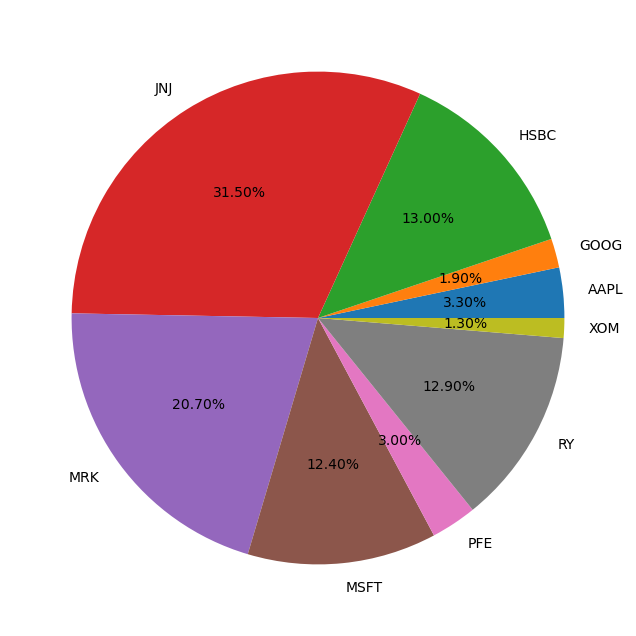

In [36]:
plt.figure(figsize=(8, 8))

W = w[w > 0]
(W * 100).plot.pie(autopct='%1.2f%%')

Ora creiamo un modello per diversi punti di $\bar{r}$ al fine di visualizzare la barriera efficiente

In [37]:
###########################################   CAN BE CHANGED  #############################################

# Number of targeted returns (or r-bar) we want to set
numR = 14

# Setting target return r-bar
r_bar = np.array([i for i in range(numR-3)])*0.0003 + 0.002 #using same increment for the first several r-bars
r_bar = np.append(r_bar,np.array([0.00505,0.0051,0.00515])) #using different increments for the last several r-bars

###########################################   CAN BE CHANGED  #############################################

In [38]:
# Print the number of target returns actually specified:
if (len(r_bar) != numR):
    numR = len(r_bar)
print("Number of targeted returns (or r-bar) specified is: ", numR)

Number of targeted returns (or r-bar) specified is:  14


In [39]:
# Two lists to record the volatility and expected return for each portfilio 
port_vol = []
port_return = []

# A matrix storing the portfolio alloaction
alloc_r = np.zeros((len(df_train.columns),numR))

# Solve the Markowitz problem for each r-bar and output the results
for i in range(numR):
    r = r_bar[i]
    print("* For the case r-bar = ", round(r*100,3), "%:")
    sol = MarkPortOpt(r, silent = True)
    
    if (not sol['success']): #check if the optimizer exit successfully
        print("NOTE: solution to this r-bar will be dropped!")
    else: #only keeping the r-bar that has sucessful optmization
        print(sol['message'])
        alloc_r[:,i] = sol['x']
        port_vol.append(sol['fun'])
        port_return.append(EReturn(sol['x']))
    print("")
    
port_vol = np.asarray(port_vol)
port_return = np.asarray(port_return)

num_rbar = len(port_vol) #update the number of r-bar recorded/kept
print("The number of recoreded the efficient frontier points is:", num_rbar)

* For the case r-bar =  0.2 %:
Optimization terminated successfully

* For the case r-bar =  0.23 %:
Optimization terminated successfully

* For the case r-bar =  0.26 %:
Optimization terminated successfully

* For the case r-bar =  0.29 %:
Optimization terminated successfully

* For the case r-bar =  0.32 %:
Optimization terminated successfully

* For the case r-bar =  0.35 %:
Optimization terminated successfully

* For the case r-bar =  0.38 %:
Optimization terminated successfully

* For the case r-bar =  0.41 %:
Optimization terminated successfully

* For the case r-bar =  0.44 %:
Optimization terminated successfully

* For the case r-bar =  0.47 %:
Optimization terminated successfully

* For the case r-bar =  0.5 %:
Optimization terminated successfully

* For the case r-bar =  0.505 %:
Optimization terminated successfully

* For the case r-bar =  0.51 %:
Optimization terminated successfully

* For the case r-bar =  0.515 %:
Optimization terminated successfully

The number of recore

In [40]:
# Display the optimal allocation for each specified target return
DF_Alloc_R = pd.DataFrame(alloc_r)
DF_Alloc_R.index = df_train.columns
DF_Alloc_R.columns = [str(round(((1 + r)**Freq - 1)*100, 1))+"%" for r in r_bar]
DF_Alloc_R = DF_Alloc_R.loc[:,(DF_Alloc_R!=0).any(axis=0)] #drop the r-bar solution(s) that failed the opt. problem

print('Optimal allocation (in %) for specified (annualized) target return:')
display(np.round(DF_Alloc_R*100, 1)) #allocation in % and round (to the 1st decimal)

Optimal allocation (in %) for specified (annualized) target return:


,10.9%,12.7%,14.5%,16.3%,18.1%,19.9%,21.8%,23.7%,25.6%,27.6%,29.6%,29.9%,30.3%,30.6%
Ticker,,,,,,,,,,,,,,
AAPL,2.6,2.7,3.8,5.7,8.7,9.2,10.8,12.6,15.5,16.5,18.6,18.9,19.2,19.4
BABA,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
BAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
BP,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
C,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
CVS,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
FRCB,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
GOOG,1.9,2.0,2.3,3.0,3.9,2.9,3.0,2.7,1.4,-0.0,-0.0,-0.0,-0.0,0.0
GS,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0


Visualizziamo ora l'intera Frontiera

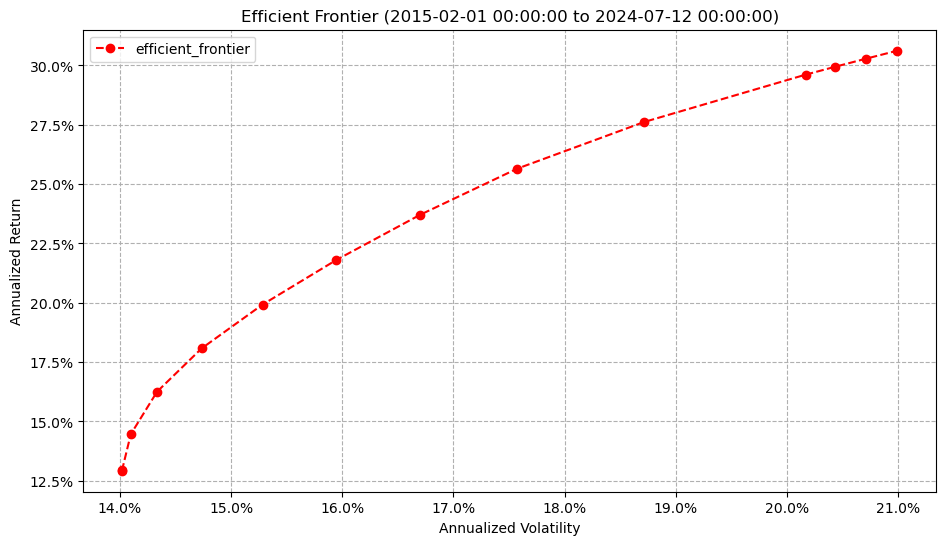

In [41]:
def ann_ret(x):
    return (x+1)**Freq-1
def ann_std(x):
    return x*np.sqrt(Freq)

# Plotting efficient frontier
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(ann_std(port_vol), ann_ret(port_return), 'ro--', label='efficient_frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier ('+str(pd.Timestamp(w_start.value))+' to '+str(pd.Timestamp(w_end.value))+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

Troviamo ora una combinazione di valori al fine di massimizzare il rapporto di sharpe, la funzione obiettivo ora diventa:

 $$ \text{max }_{w \in \mathbb{R}^n} \frac{\mu^T w - r_{f}}{ \sqrt{w^T Q w}}$$
 
 Con i seguenti vincoli:
 
1) vincolo di budget: $$ \textbf{1}^T w = 1 $$
2) non vogliamo pesi negativi: $$w \geq 0$$

In [42]:
# Function to compute the annualized sharpe ratio for the portfolio given portfolio weight
# Note that it returns the -1 * Annualized Sharpe Ratio 
def AnnSR(w, data = df_train, rf = fed_train.mean()):
    excess_ret = data @ w - rf 
    AnnSR = ann_ret(excess_ret.mean())/ann_std(PVol(w))
    return AnnSR


# Function to find the optimal portfolio that maximize the Sharpe ratio 
# Returns the optimal solution
def MaxSR(data = df_train, rf = fed_train.mean(), silent = False):
    
    #Objective Function
    def SR(w):
        excess_ret = data @ w - rf 
        SR = (excess_ret.mean())/(PVol(w))
        return -SR
    
    n = len(data.columns)
    
    #Bounds
    bnds = tuple((0,1) for i in range(n)) # nonnegativity constraint

    # Constraints
    def constraint1(w):
        return np.sum(w) - 1.0 # budget constraint   
    cons = {'type': 'eq', 'fun': constraint1}
    
    # Initial x0
    w0 = np.array(np.ones(n))
    
    # Solve the problem
    sol = minimize(SR, w0, method='SLSQP', bounds=bnds, constraints=cons)
    
    # Whether the solution will be printed
    if(not silent):
        print("Solution to the Max Sharpe Ratio Problem is:")
        print(sol)
        print("")
    elif (not sol['success']): #check if the optimizer exist successfully
        print("WARNING:  the optimizer did NOT exit successfully!!")
        
    return sol

In [43]:
# Find the optimal portfolio that maximize Sharpe Ratio
sol = MaxSR()
w_SR = sol['x'] #the portfolio weight with highest Sharpe Ratio

# Calculate the volatility and expected return for the optimal portfolio
opt_vol = PVol(sol['x'])
opt_return = EReturn(sol['x'])
sr = AnnSR(sol['x'])

# Print (annualized) return, volatiltiy and Sharpe ratio information
print("* The expected return (annualized) for the optimal portfolio is ", ann_ret(opt_return) )
print("* The volatility (annualized) for the optimal portfolio is ", ann_std(opt_vol) )
print("* The Sharpe ratio (annualized) for the optimal portfolio is ", sr)
print()

# Display the optimal allocation after adding in the allocation correspond to the max SR
DF_Alloc_R['maxSR'] = w_SR 
print('Optimal allocation (in %) for specified target return:')
np.round(DF_Alloc_R*100, 1) #allocation in % and round (to the 1st decimal)

Solution to the Max Sharpe Ratio Problem is:
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.16916899317134013
       x: [ 1.616e-01  0.000e+00 ...  6.085e-18  0.000e+00]
     nit: 13
     jac: [-1.214e-02  9.364e-02 ...  5.354e-02  3.702e-03]
    nfev: 299
    njev: 13

* The expected return (annualized) for the optimal portfolio is  0.27410424304786063
* The volatility (annualized) for the optimal portfolio is  0.1858216597388483
* The Sharpe ratio (annualized) for the optimal portfolio is  1.3659020163735738

Optimal allocation (in %) for specified target return:


,10.9%,12.7%,14.5%,16.3%,18.1%,19.9%,21.8%,23.7%,25.6%,27.6%,29.6%,29.9%,30.3%,30.6%,maxSR
Ticker,,,,,,,,,,,,,,,
AAPL,2.6,2.7,3.8,5.7,8.7,9.2,10.8,12.6,15.5,16.5,18.6,18.9,19.2,19.4,16.2
BABA,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
BAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BP,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
C,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0
CVS,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0
FRCB,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0
GOOG,1.9,2.0,2.3,3.0,3.9,2.9,3.0,2.7,1.4,-0.0,-0.0,-0.0,-0.0,0.0,0.0
GS,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0


Visualizziamo ora la frontiera efficiente

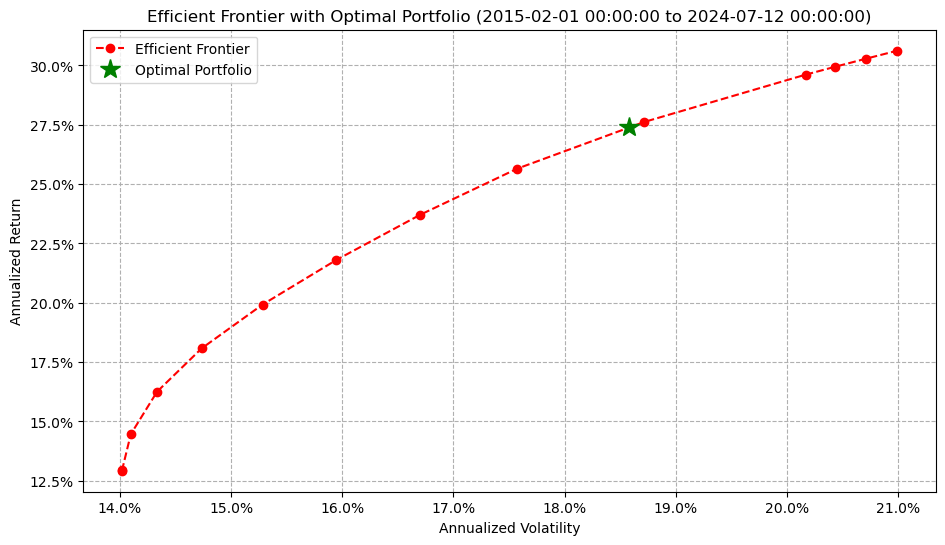

In [44]:
# Plotting efficient frontier and mark the portfolio with maximum Sharpe ratio
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(ann_std(port_vol), ann_ret(port_return), 'ro--', label='Efficient Frontier') #plot efficient frontier
plt.plot(ann_std(opt_vol), ann_ret(opt_return), 'g*', markersize=15, label='Optimal Portfolio') #plot max SR portfolio
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier with Optimal Portfolio ('+str(pd.Timestamp(w_start.value))+' to '+str(pd.Timestamp(w_end.value))+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

<Axes: >

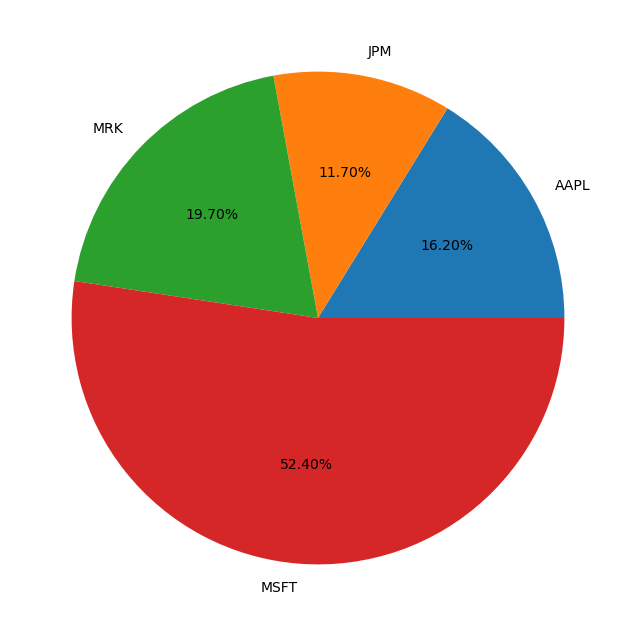

In [45]:
plt.figure(figsize=(8, 8))
w = pd.Series(data=np.round(w_SR, n_dec), index=data_train_mean.index)
W = w[w > 0]
(W * 100).plot.pie(autopct='%1.2f%%')

Ora cosa succede se inseriamo gli assett risk free nel nostro portafogli? Ricalcoliamo per vedere come varia la frontiera efficiente.



In [46]:
df_train_with_rf = df_train.copy()
df_train_with_rf = df_train_with_rf.join(fed_train.to_frame('TBILL'))

In [47]:
df_train_with_rf

,AAPL,BABA,BAC,BP,C,CVS,FRCB,GOOG,GS,HSBC,...,MS,MSFT,PFE,PNC,RY,SHEL,USB,WFC,XOM,TBILL
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,0.036998,-0.136068,-0.036872,-0.001800,-0.034143,-0.024448,-0.002962,-0.010056,-0.044767,-2.370256e-02,...,-0.035340,-0.143705,-0.036980,-0.020167,-0.068171,-0.057371,-0.032549,-0.025159,-0.038178,0.000004
2015-02-08,0.019113,-0.038168,0.088449,0.060263,0.046646,0.024959,0.084642,-0.006585,0.063917,2.974625e-02,...,0.058563,0.049753,0.070804,0.069790,0.072981,0.077950,0.059652,0.055641,0.054550,0.000004
2015-02-15,0.068528,0.039332,0.007277,0.033492,0.041921,0.020077,0.021365,0.033917,0.030366,-2.017858e-02,...,0.027661,0.034426,0.044317,0.021451,0.025362,0.015656,0.014862,0.016162,0.020437,0.000002
2015-02-22,0.019043,-0.027063,-0.013848,-0.015502,0.011328,0.000682,0.003900,-0.018324,0.013280,1.192280e-02,...,-0.001087,0.006887,-0.002310,-0.001191,-0.026823,-0.007841,-0.009985,-0.009037,-0.036950,0.000004
2015-03-01,-0.008031,-0.017544,-0.034798,0.003876,0.012360,0.011392,0.006533,0.036089,-0.005870,-4.413007e-02,...,-0.025857,-0.000228,-0.006945,-0.003360,0.033504,-0.006535,-0.000224,-0.000730,-0.015347,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-09,0.024135,0.000894,0.000799,-0.061485,-0.008506,0.036577,-0.201597,0.011439,-0.003527,-4.927154e-03,...,-0.007154,0.021005,-0.002791,-0.009594,-0.026357,-0.045754,-0.037731,-0.026035,-0.038462,0.000984
2024-06-16,0.079232,-0.044202,-0.013575,-0.010493,-0.039657,-0.025251,0.250000,0.014908,-0.018575,-2.723388e-02,...,-0.016883,0.044167,-0.036739,-0.030729,-0.023028,-0.006479,-0.004869,-0.016450,-0.032284,0.000984
2024-06-23,-0.023530,0.004363,0.006371,0.017770,0.011124,0.019097,-0.400000,0.010596,0.008332,6.478431e-03,...,0.006911,0.016291,0.007628,0.013965,-0.002983,0.013623,0.022405,0.012195,0.015122,0.000983


In [48]:
# Get the mean and covariance matrix of the training data
data_train_with_rf_mean = df_train_with_rf.mean()
data_train_with_rf_cov_mat = df_train_with_rf.cov()

# Function to compute the expected return for the portfolio
def EReturn_with_rf(w):
    EReturn = w @ data_train_with_rf_mean
    return EReturn

# Function to compute the portfolio standard deviation
def PVol_with_rf(w):
    pvar = w @ data_train_with_rf_cov_mat @ w
    return np.sqrt(pvar)

# Function to solve for the optimal solution to the Markowitz Portfolio Optimization Problem 
# with specified target return r
def MarkPortOpt_with_rf(r, silent = False):

    # Constraints
    def constraint1(w):
        return np.sum(w) - 1.0 # budget constraint   
    def constraint2(w):
        return 1.0 - np.sum(w) # budget constraint
    def constraint3(w):
        return w[:-1] # nonnegative constraint placed on stock returns only
    def constraint4(w):
        diff = EReturn_with_rf(w) - r
        return diff # return constraint    
    con1 = {'type': 'ineq', 'fun': constraint1}
    con2 = {'type': 'ineq', 'fun': constraint2}
    con3 = {'type': 'ineq', 'fun': constraint3}
    con4 = {'type': 'ineq', 'fun': constraint4}
    cons = ([con1,con2,con3,con4])

    # Initial x0
    w0 = np.ones(len(df_train_with_rf.columns))

    # Solve the problem
    sol = minimize(PVol_with_rf, w0, method='SLSQP',constraints=cons)
    
    # Whether the solution will be printed
    if(not silent):
        print("Solution to the Markowitz Problem with r =  ", round(r*100,3), "%:")
        print(sol)
        print("")
    elif (not sol['success']): #check if the optimizer exist successfully
        print("WARNING:  the optimizer did NOT exit successfully!!")
        
    return sol

In [49]:
# Two lists to record the volatility and expected return for each portfilio 
port_vol_with_rf = []
port_return_with_rf = []

# Solve the Markowitz problem for each r-bar and output the results
for i in range(numR):
    r = r_bar[i]
    print("* For the case r-bar = ", round(r*100,3), "%:")
    sol = MarkPortOpt_with_rf(r, silent = True)
    
    if (not sol['success']): #check if the optimizer exist successfully
        print("NOTE: solution to this r-bar will be dropped!")
    else: #only keeping the r-bar that has sucessful optmization
        print(sol['message'])
        port_vol_with_rf.append(sol['fun'])
        port_return_with_rf.append(EReturn_with_rf(sol['x']))
    print("")
    
port_vol_with_rf = np.asarray(port_vol_with_rf)
port_return_with_rf = np.asarray(port_return_with_rf)

num_rbar = len(port_vol_with_rf) #update the number of r-bar recorded/kept
print("The number of recoreded the efficient frontier points is:", num_rbar)

* For the case r-bar =  0.2 %:
Optimization terminated successfully

* For the case r-bar =  0.23 %:
Optimization terminated successfully

* For the case r-bar =  0.26 %:
Optimization terminated successfully

* For the case r-bar =  0.29 %:
Optimization terminated successfully

* For the case r-bar =  0.32 %:
Optimization terminated successfully

* For the case r-bar =  0.35 %:
Optimization terminated successfully

* For the case r-bar =  0.38 %:
Optimization terminated successfully

* For the case r-bar =  0.41 %:
Optimization terminated successfully

* For the case r-bar =  0.44 %:
Optimization terminated successfully

* For the case r-bar =  0.47 %:
Optimization terminated successfully

* For the case r-bar =  0.5 %:
Optimization terminated successfully

* For the case r-bar =  0.505 %:
Optimization terminated successfully

* For the case r-bar =  0.51 %:
Optimization terminated successfully

* For the case r-bar =  0.515 %:
Optimization terminated successfully

The number of recore

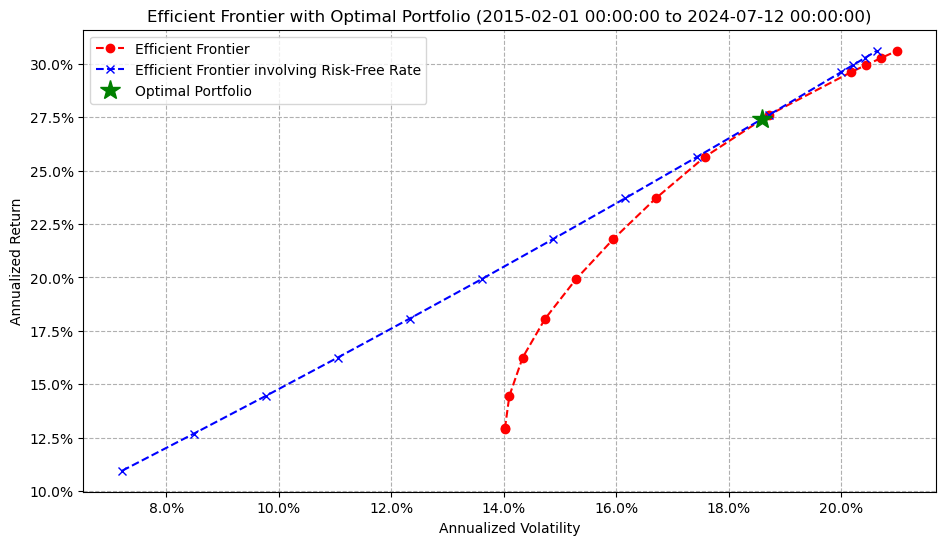

In [50]:
# Plotting efficient frontiers and mark the portfolio with maximum Sharpe ratio
plt.rcParams['figure.figsize'] = (11, 6)
plt.plot(ann_std(port_vol), ann_ret(port_return), 'ro--', label='Efficient Frontier') #plot efficient frontier
plt.plot(ann_std(port_vol_with_rf), ann_ret(port_return_with_rf), 'bx--', 
         label='Efficient Frontier involving Risk-Free Rate') #plot efficient frontier involving risk-free rate
plt.plot(ann_std(opt_vol), ann_ret(opt_return), 'g*', markersize=15, label='Optimal Portfolio') #plot max SR portfolio
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.grid(True, linestyle='--')
plt.legend()
plt.title('Efficient Frontier with Optimal Portfolio ('+str(pd.Timestamp(w_start.value))+' to '+str(pd.Timestamp(w_end.value))+')')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

Ora supponiamo di voler costruire un portafoglio nel seguente modo:

* il 90% lo vorremmo mettere in in portafoglio azionario ottimizzato tramite max Sharpe
* il 10% in un investimento risk free

Quale sarà il rischio o la volatilita del portafoglio? 
Ricordiamo che il rishio di portafoglio si misura come $$\text{Portfolio Risk} = \sqrt{w^T Q w}$$ 

dove $w$ è un vettore rappresentante i pesi del portafoglio e $Q$ rappresenta la matrice di covarianza



In [51]:
# Calculate the portfolio weight (90% max Sharpe + 10% risk-free rate)
w_port1 = np.append(0.9 * w_SR, 0.1)

# Calculate the portfolio risk
risk_port1 = np.sqrt( w_port1 @ data_train_with_rf_cov_mat @ w_port1)

print('The new portfolio risk (annualized) is:', ann_std(risk_port1))
print('The portfolio risk (annualized) for the max Sharpe point was:', ann_std(PVol(w_SR)))

The new portfolio risk (annualized) is: 0.16724650798415452
The portfolio risk (annualized) for the max Sharpe point was: 0.1858216597388483


Ora supponiamo di prendere a prestito i tbill al fine di mettere a leva il portafoglio max sharpe avremo così un portafoglio con il 120%

In [52]:
# Calculate the portfolio weight (borrowing at risk-free rate and levering max Sharpe point)
w_port2 = np.append(1.2*w_SR, -0.2)

# Calculate the portfolio risk
risk_port2 = np.sqrt( w_port2 @ data_train_with_rf_cov_mat @ w_port2)

print('The new portfolio risk (annualized) is:', ann_std(risk_port2))
print('The portfolio risk (annualized) for the max Sharpe point was:', ann_std(PVol(w_SR)))

The new portfolio risk (annualized) is: 0.22297284554274438
The portfolio risk (annualized) for the max Sharpe point was: 0.1858216597388483


## BackTest 

Fino ad ora abbiamo costruito un portafoglio ottimizzato in codizioni ideali abbiamo fatto degli assunti sulla matrice di covarianza e sui rendimenti.

Dobbiamo però provare i nostri ragionamenti in condizioni reali con asimmetrie e kurtosi sul periodo storico.

In [53]:
###########################################   CAN BE CHANGED  #############################################

# Specify the start and end date for the back test  (can also use BT_startdate = 'YYYY-MM-DD') 
# CAUTION: Make sure that the date is within our specified time period from Section 1
BT_startdate = str(df_week.index[0].date())
BT_enddate = str(df_week.index[-1].date())

###########################################   CAN BE CHANGED  #############################################

In [54]:
# Trim dataset to have the specified start and end dates for the historical back test
data_BT = df_week[BT_startdate:BT_enddate].copy()
SP500_BT = SP500[BT_startdate:BT_enddate].copy()
TBill_BT = fed_data[BT_startdate:BT_enddate].copy()

## Strategia acquista e mantieni

In [75]:
def ann_std(x):
    return x*np.sqrt(Freq)


# Functions to calculate the portfolio return for back-testing given portfolio weight
# Return the portfolio return over the full back-testing period
# Buy-and-hold strategy
def portRet_BH(w): 
    n = data_BT.shape[0]
    PR = np.zeros(n) 
    X = w * 1 #initial wealth assume to be 1
    for i in range(n):
        W = (1+data_BT.iloc[i]) @ X #wealth after each period
        PR[i] = (W - np.sum(X))/np.sum(X) #calculate and record portfolio return for that period
        X = (1+data_BT.iloc[i]) * X #how much of the wealth is invested in each asset
    return PR

# Function to display the summary statistics of the back test results
# It takes in the portfolio returns dataframe and returns the mean and standard deviation of the portfolio returns
def DisplaySummary_BT(PR, n_dec = 2):
    col_names = PR.columns
    
    # Compute and display summary statistics for each portfolio
    print('Summary statistic of various allocations for the back test (from '+
          str(BT_startdate)+' to '+str(BT_enddate)+'):')
    PR_mean = PR.mean()
    PR_std = PR.std()
    BT = pd.DataFrame(index = col_names)
    BT['Geo Mean(Annu,%)'] = np.round( PR.apply(geometric_mean,periods_per_year=Freq) *100, n_dec)
    BT['Std(Annu,%)'] = np.round( ann_std(PR.std()) *100, n_dec)
    BT['Sharpe Ratio (Annu)'] = np.round( PR.apply(annualize_sharpe, risk_free_rate=fed_data,periods_per_year=Freq), n_dec)
    BT['Max Drawdown(%)'] = np.round(PR.apply(max_drawdown)*100, n_dec)
    display(BT)
    
    return PR_mean,PR_std

In [69]:
# Add the equal weighted portfolio to our portfolio allocation dataframe
n_stocks = len(df_week.columns)
w_EQ = np.array(np.ones(n_stocks))/n_stocks
DF_Alloc_R['Equal'] = w_EQ

In [70]:
DF_Alloc_R

,10.9%,12.7%,14.5%,16.3%,18.1%,19.9%,21.8%,23.7%,25.6%,27.6%,29.6%,29.9%,30.3%,30.6%,maxSR,Equal
Ticker,,,,,,,,,,,,,,,,
AAPL,2.604646e-02,2.670476e-02,3.779344e-02,5.731720e-02,8.684040e-02,9.228085e-02,1.075731e-01,1.256170e-01,1.546122e-01,1.651865e-01,1.858678e-01,1.894491e-01,1.920354e-01,1.939734e-01,1.615884e-01,0.045455
BABA,4.856905e-17,-6.831325e-17,-4.999094e-17,-4.393656e-17,-4.501862e-17,-2.995405e-17,-1.940879e-17,2.035498e-17,-2.705879e-17,-5.029720e-17,1.554530e-17,2.178112e-17,2.288781e-17,1.302866e-17,0.000000e+00,0.045455
BAC,3.727263e-18,4.519276e-17,1.775446e-18,1.182029e-17,1.743404e-17,9.722821e-18,1.027536e-17,-4.542806e-17,8.417362e-17,5.655272e-17,3.590740e-17,9.392489e-19,1.279348e-17,2.647468e-17,0.000000e+00,0.045455
BP,7.274179e-18,5.889345e-18,3.269728e-17,-2.516308e-19,9.020225e-18,1.539495e-17,-6.766223e-19,1.195053e-17,-5.604372e-17,-9.089121e-17,-2.450384e-19,7.543756e-17,-5.611737e-17,-4.320243e-18,0.000000e+00,0.045455
C,1.161549e-18,9.648545e-18,-2.208394e-17,2.109344e-17,2.296892e-18,-6.859080e-18,4.457429e-18,2.512950e-17,-3.911692e-17,-1.052467e-16,3.471352e-17,2.357981e-18,-4.783321e-18,2.090448e-17,3.537210e-18,0.045455
CVS,1.411673e-18,-1.399246e-17,-2.121972e-17,3.900295e-17,1.138414e-17,-7.008081e-18,2.161111e-17,2.807880e-17,-5.016776e-18,-7.361671e-17,1.006634e-18,5.416397e-17,-5.088313e-17,-9.558870e-18,2.705084e-17,0.045455
FRCB,8.525793e-18,1.163759e-18,-9.973202e-18,3.502599e-18,-1.120915e-17,-2.527529e-17,9.623491e-19,3.604074e-17,-4.158691e-17,-3.862631e-17,1.249893e-17,1.412171e-17,-2.647897e-17,4.050881e-17,0.000000e+00,0.045455
GOOG,1.924228e-02,2.043430e-02,2.301319e-02,3.049258e-02,3.875943e-02,2.931499e-02,2.954924e-02,2.744510e-02,1.369518e-02,-5.947094e-17,-4.763635e-17,-4.041115e-17,-9.309859e-17,2.267195e-17,5.746272e-17,0.045455
GS,-9.553874e-19,-1.294566e-17,-2.515107e-17,1.774422e-17,1.044846e-17,-1.753943e-17,-3.903142e-18,-3.032856e-17,6.316976e-17,7.787179e-17,2.363641e-17,-3.862435e-17,9.962134e-18,-5.071836e-18,0.000000e+00,0.045455


In [71]:
# Calculate the weekly portfolio return for each asset mix in df_alloc_r 
# (note: takes a bit time for this block to run)
col_names = DF_Alloc_R.columns
PR_BH = pd.DataFrame(index = data_BT.index, columns = col_names)
for i in range(len(col_names)):
    w = DF_Alloc_R.iloc[:,i].values
    PR_BH[col_names[i]] = portRet_BH(w)  

In [76]:
# Display Results for Buy-and_Hold strategy
print('Using Buy-and-Hold strategy: ')
PR_BH_mean,PR_BH_std = DisplaySummary_BT(PR_BH)

Using Buy-and-Hold strategy: 
Summary statistic of various allocations for the back test (from 2015-02-01 to 2025-01-12):


,"Geo Mean(Annu,%)","Std(Annu,%)",Sharpe Ratio (Annu),Max Drawdown(%)
10.9%,12.11,14.15,13.48,-22.85
12.7%,12.15,14.16,13.56,-22.88
14.5%,13.77,14.73,16.27,-23.16
16.3%,15.45,15.50,19.23,-23.59
18.1%,17.00,16.33,22.09,-23.96
19.9%,18.39,17.06,24.92,-24.57
21.8%,19.61,17.67,27.62,-25.21
23.7%,20.75,18.33,30.23,-25.68
25.6%,21.99,19.09,33.25,-25.86
27.6%,23.30,20.04,36.57,-27.94
